# Manhattan Satellite Imagery Analysis with OpenEO

## Overview

This notebook demonstrates how to retrieve and visualize satellite imagery of Manhattan using the OpenEO API. We'll use Sentinel-2 data to create a true-color RGB image of the Manhattan area.

In [8]:
# Import required packages

import openeo
from openeo.processes import process
from IPython.display import Image

## Connect to the OpenEO Backend

We connect to the OpenEO backend service and authenticate using OpenID Connect. This establishes a connection to the remote processing service where our satellite data is stored.

In [9]:
# Connect to the back-end

# connection = openeo.connect("https://openeo.ds.io").authenticate_oidc()
connection = openeo.connect(url="http://127.0.0.1:8081/").authenticate_oidc()

Authenticated using refresh token.


## Define Spatial Extent

We define the geographic boundaries of our area of interest using longitude and latitude coordinates. This bounding box covers the Manhattan island area of New York City.

In [10]:
spatial_extent_east = -73.90
spatial_extent_north = 40.80
spatial_extent_south = 40.70
spatial_extent_west = -74.00

## Load Sentinel-2 Data

We load Sentinel-2 satellite imagery for our defined area using the `load_collection_and_reduce` process. 
- We select the RGB bands (B04=Red, B03=Green, B02=Blue) for true-color visualization
- The temporal extent covers April to December 2022
- The "first" pixel selection method means we'll use the first available cloud-free pixel in the time range

In [11]:
load1 = connection.datacube_from_process(
    "load_collection_and_reduce",
    id="sentinel-2-global-mosaics",
    bands=["B04", "B03", "B02"],
    properties={},
    spatial_extent={
        "east": spatial_extent_east,
        "north": spatial_extent_north,
        "south": spatial_extent_south,
        "west": spatial_extent_west,
    },
    temporal_extent=["2022-04-15T00:00:00Z", "2022-12-31T00:00:00Z"],
    pixel_selection="first",
)

## Scale Image Values

Raw satellite reflectance values need to be scaled to standard RGB display range (0-255). We define a processing function that:
1. Scales the values from their original range (0-10000) to 0-255
2. Applies truncation to ensure all values are valid integers within range

In [12]:
def process1(x, context=None):
    data1 = process(
        "linear_scale_range", inputMax=10000, inputMin=0, outputMax=255, x=x
    )
    data2 = process("trunc", x=data1)
    return data2

## Apply Processing and Enhance Visual Appearance

We apply the scaling function to our data cube, then use a color formula to enhance the visual appearance of the image. The color formula applies:
- Gamma correction (RGB 1.5) to adjust brightness and contrast
- Sigmoidal contrast enhancement (RGB 10 0.3) to improve detail visibility
- Saturation adjustment to enhance color vibrancy

In [13]:
processed = load1.apply(process=process1)

color = processed.process(
    "color_formula",
    data=processed,
    formula="Gamma RGB 1.5 Sigmoidal RGB 10 0.3 Saturation 1",
)

## Save and Display Result

Finally, we save the processed image as a PNG file and display it. This shows the true-color satellite view of Manhattan and surrounding areas.

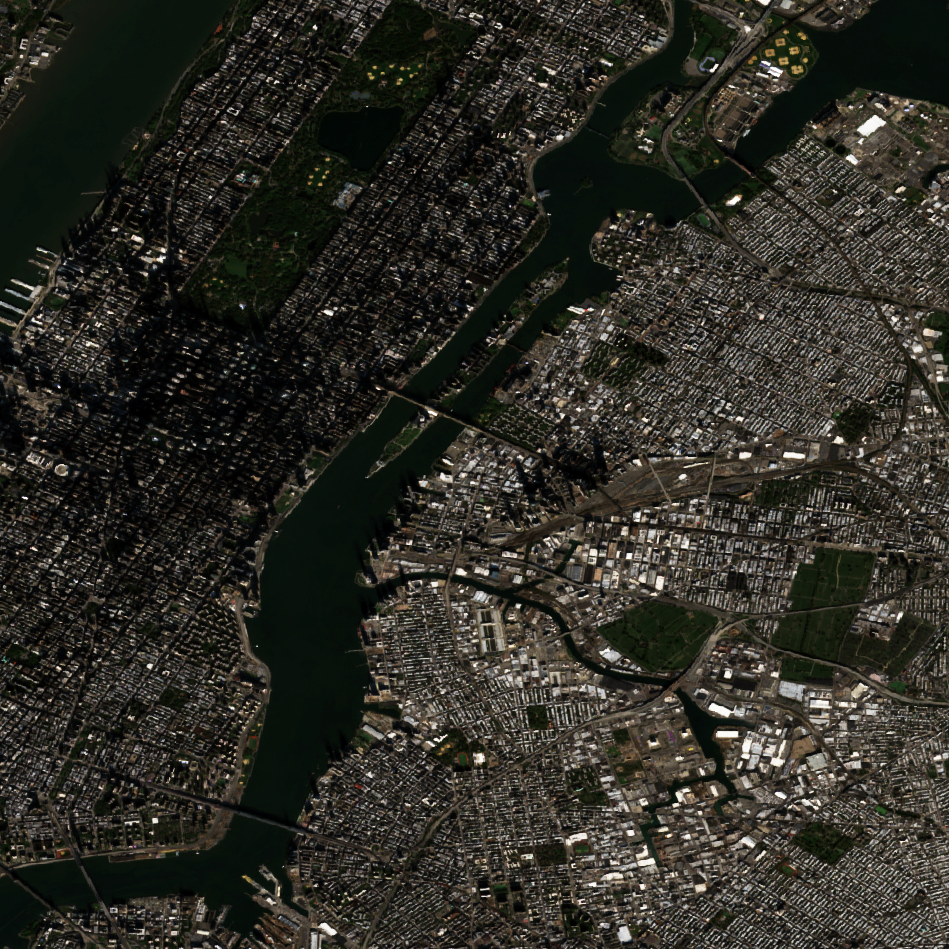

In [14]:
save5 = color.save_result(format="PNG")

# The process can be executed synchronously (see below), as batch job or as web service now
result = connection.download(save5)
Image(result)

## Conclusion

This notebook demonstrates how to use OpenEO to access, process, and visualize satellite imagery for urban areas. The workflow can be extended to include additional analysis, such as:

- Time series analysis to observe changes over multiple dates
- Land cover classification to identify different urban features
- Spectral indices to analyze vegetation, water, or built-up areas
- Image segmentation to extract specific features